In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btc-1h/btc_1h.csv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 2.9 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 29989631.30


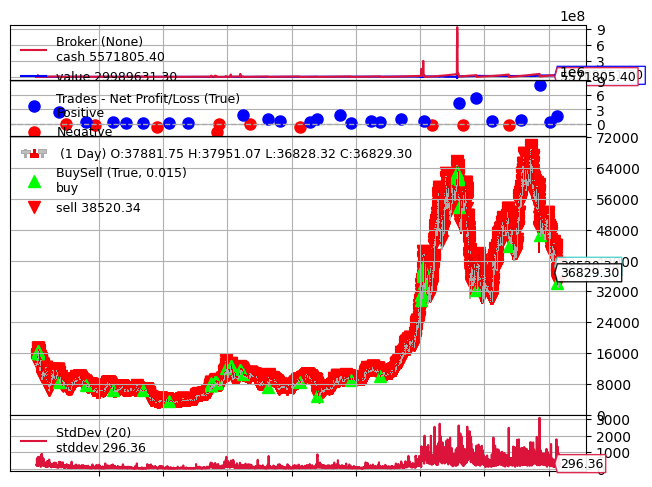

Sharpe Ratio: 0.7944927444737477


In [2]:
!pip install backtrader matplotlib numpy scipy

import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

class RandomWalkVolatilityStrategy(bt.Strategy):
    params = (
        ("lookback_period", 20),
        ("transaction_cost", 0.0015),
    )

    def __init__(self):
        self.rolling_volatility = bt.indicators.StdDev(self.data.close, period=self.params.lookback_period)

    def next(self):
        if self.rolling_volatility[0] < self.rolling_volatility[-1]:
            self.buy(size=self.calculate_position_size(), exectype=bt.Order.Market)
        elif self.rolling_volatility[0] > self.rolling_volatility[-1]:
            self.sell(size=self.calculate_position_size(), exectype=bt.Order.Market)

    def calculate_position_size(self):
        risk_per_trade = self.broker.getvalue() * 0.01  
        if self.rolling_volatility[0] < self.rolling_volatility[-1]:
            position_size = min(risk_per_trade / self.params.transaction_cost, self.broker.get_cash() / self.data.close[0])
        elif self.rolling_volatility[0] > self.rolling_volatility[-1]:
            position_size = -min(risk_per_trade / self.params.transaction_cost, self.broker.get_cash() / self.data.close[0])
        else:
            position_size = 0
        min_valid_size = 1  
        max_valid_size = 1000  
        position_size = max(min(position_size, max_valid_size), min_valid_size)
        return position_size


if __name__ == '__main__':
    
    data = bt.feeds.PandasData(dataname=pd.read_csv('/kaggle/input/btc-1h/btc_1h.csv', index_col=0, parse_dates=True))
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(RandomWalkVolatilityStrategy)
    cerebro.broker.set_cash(100000)
    cerebro.broker.setcommission(commission=0.0015)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    final_portfolio_value = cerebro.broker.getvalue()
    if not pd.isna(final_portfolio_value):
        print('Ending Portfolio Value: %.2f' % final_portfolio_value)
    else:
        print('Ending Portfolio Value: NaN')
    cerebro.plot(style='candlestick', iplot=False, volume=False)   
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.Returns)
    strategies = cerebro.run()
    strat = strategies[0]
    print('Sharpe Ratio:', strat.analyzers.sharperatio.get_analysis()['sharperatio'])
    plt.show()

Sharpe Ratio: 0.5706939777374403
total return:  5.890060481782727
Annualized Return Percentage: 60.42767073952891


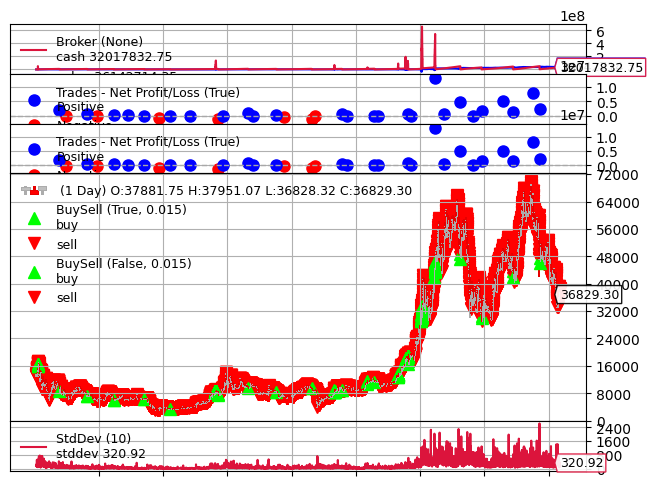

In [3]:
!pip install backtrader matplotlib numpy scipy

import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

class RLVolatilityStrategy(bt.Strategy):
    params = (
        ("lookback_period", 10),
        ("transaction_cost", 0.0015),
    )
    def __init__(self):
        self.rolling_volatility = bt.indicators.StdDev(self.data.close, period=self.params.lookback_period)
    def next(self):
        if self.rolling_volatility[0] < self.rolling_volatility[-1]:
            self.buy(size=self.calculate_position_size(), exectype=bt.Order.Market)
        elif self.rolling_volatility[0] > self.rolling_volatility[-1]:
            self.sell(size=self.calculate_position_size(), exectype=bt.Order.Market)
    def calculate_position_size(self):
        risk_per_trade = self.broker.getvalue() * 0.01
        if self.rolling_volatility[0] < self.rolling_volatility[-1]:
            position_size = min(risk_per_trade / self.params.transaction_cost, self.broker.get_cash() / self.data.close[0])
        elif self.rolling_volatility[0] > self.rolling_volatility[-1]:
            position_size = -min(risk_per_trade / self.params.transaction_cost, self.broker.get_cash() / self.data.close[0])
        else:
            position_size = 0
        min_valid_size = 1
        max_valid_size = 1000
        position_size = max(min(position_size, max_valid_size), min_valid_size)
        return position_size

if __name__ == '__main__':
    
    data = bt.feeds.PandasData(dataname=pd.read_csv('/kaggle/input/btc-1h/btc_1h.csv', index_col=0, parse_dates=True))
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(RLVolatilityStrategy)
    cerebro.broker.set_cash(100000)
    cerebro.broker.setcommission(commission=0.0015)
    cerebro.addobserver(bt.observers.Trades)
    cerebro.addobserver(bt.observers.BuySell)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.Returns)
    strategies = cerebro.run()
    strat = strategies[0]
    print('Sharpe Ratio:', strat.analyzers.sharperatio.get_analysis()['sharperatio'])
    total_return = strat.analyzers.returns.get_analysis()['rtot']
    print('total return: ', total_return)
    start_date = cerebro.datas[0].datetime.date(0)
    end_date = cerebro.datas[0].datetime.date(-1)
    num_years = 4.08333
    annualized_return = (total_return + 1) ** (1 / num_years) - 1
    print('Annualized Return Percentage:', annualized_return * 100)
    cerebro.plot(style='candlestick', iplot=False, volume=False)

Epoch 1/10
891/891 [==============================] - 28s 17ms/step - loss: 2.4797e-04 - val_loss: 2.2611e-04
Epoch 2/10
891/891 [==============================] - 13s 15ms/step - loss: 7.7493e-05 - val_loss: 1.8646e-04
Epoch 3/10
891/891 [==============================] - 13s 15ms/step - loss: 6.2037e-05 - val_loss: 5.3415e-04
Epoch 4/10
891/891 [==============================] - 13s 14ms/step - loss: 5.9022e-05 - val_loss: 7.2172e-04
Epoch 5/10
891/891 [==============================] - 13s 15ms/step - loss: 5.3255e-05 - val_loss: 9.3132e-04
Epoch 6/10
891/891 [==============================] - 13s 15ms/step - loss: 4.5949e-05 - val_loss: 1.9799e-04
Epoch 7/10
891/891 [==============================] - 13s 15ms/step - loss: 4.5443e-05 - val_loss: 3.5779e-04
Epoch 8/10
891/891 [==============================] - 13s 15ms/step - loss: 4.2518e-05 - val_loss: 9.8127e-05
Epoch 9/10
891/891 [==============================] - 13s 15ms/step - loss: 3.8946e-05 - val_loss: 2.9042e-04
Epoch 10/1

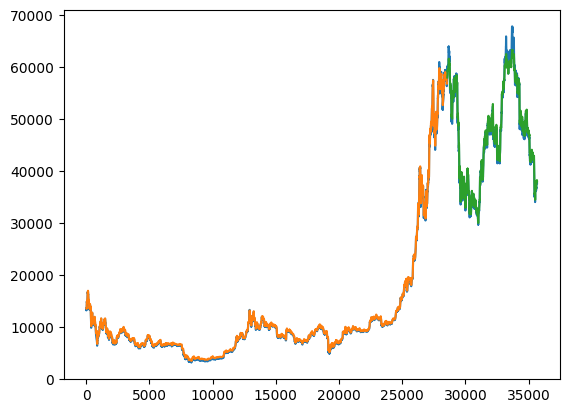

The Sharpe Ratio for the given datasets is 1.00.
             close
0     57985.003906
1     58014.855469
2     58040.335938
3     58066.464844
4     58089.875000
...            ...
7097  38216.296875
7098  38187.480469
7099  38156.277344
7100  38126.847656
7101  38103.003906

[7102 rows x 1 columns]
Maximum Drawdown: 52.6077%
Annualized Return: 28.8899%


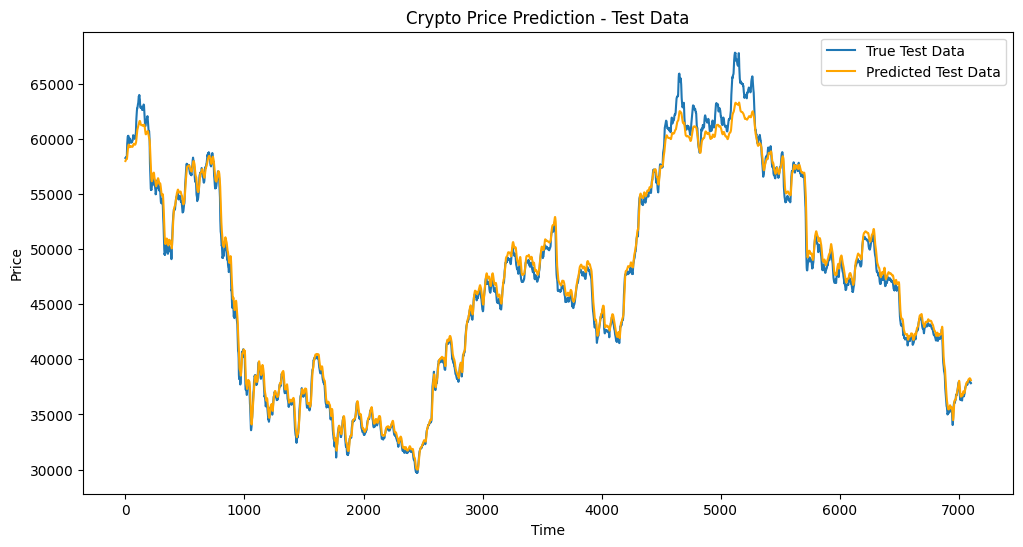

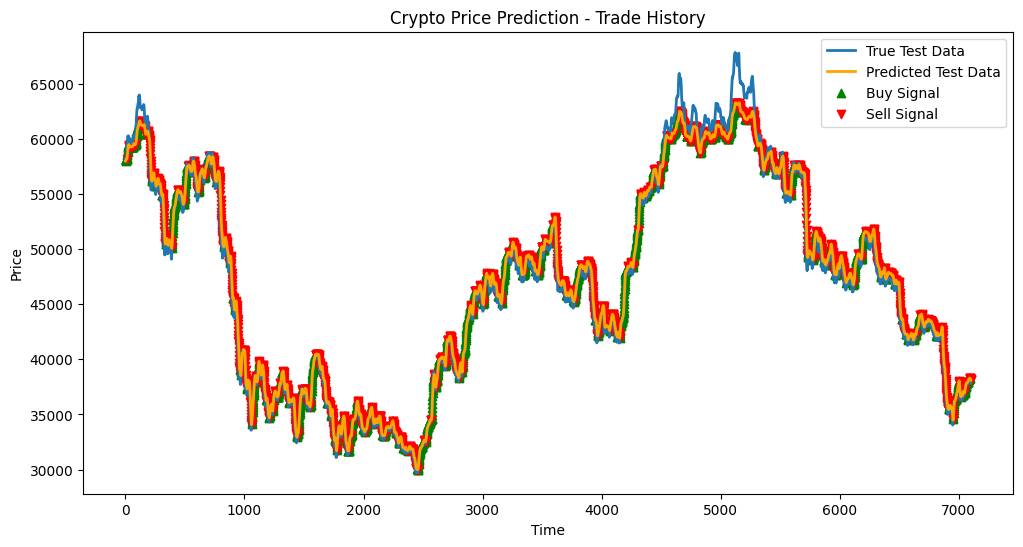

R-squared Score: -24.46928045261649


In [4]:
import pandas as pd
df=pd.read_csv('/kaggle/input/btc-1h/btc_1h.csv')
df.dropna()
span = 10
df['ema'] = df['close'].ewm(span=span, adjust=False).mean()
df['ema_2'] = df['open'].ewm(span=span, adjust=False).mean()
df['ema_3'] = df['high'].ewm(span=span, adjust=False).mean()
df['ema_4'] = df['low'].ewm(span=span, adjust=False).mean()
df['ema_5'] = df['volume'].ewm(span=span, adjust=False).mean()
df1=df.reset_index()['ema']
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional
from keras.layers import Dropout
from keras.layers import BatchNormalization
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(30, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,verbose=1)
import tensorflow as tf
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_train=y_train.reshape(-1,1)
y_train=scaler.inverse_transform(y_train)
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(ytest)
math.sqrt(mean_squared_error(ytest,test_predict))
import matplotlib.pyplot as plt
look_back=30
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
import numpy as np
def sharpe_ratio(ytest, y_predicted, risk_free_rate):
    excess_returns = abs(y_predicted - ytest)
    excess_returns_mean = np.mean(excess_returns)
    excess_returns_std = np.std(excess_returns)
    sharpe_ratio = (excess_returns_mean - risk_free_rate) / excess_returns_std
    return sharpe_ratio
risk_free_rate = 0.02
sharpe_ratio_value = sharpe_ratio(ytest, test_predict, risk_free_rate)
print(f"The Sharpe Ratio for the given datasets is {sharpe_ratio_value:.2f}.")
import matplotlib.pyplot as plt
import pandas as pd
df_new = pd.DataFrame(test_predict, columns=['close'])
print(df_new)
import pandas as pd
df_new['Daily_Return'] = df_new['close'].pct_change()
peak_index = df_new['close'].idxmax()
trough_index = df_new['close'].idxmin()
max_drawdown = (df_new['close'].iloc[peak_index] - df_new['close'].iloc[trough_index]) / df_new['close'].iloc[peak_index]
print(f"Maximum Drawdown: {max_drawdown:.4%}")
total_return = df_new['close'].iloc[-1] / df['close'].iloc[0] - 1
num_years = 4.08
annualized_return = (1 + total_return) ** (1 / num_years) - 1
print(f"Annualized Return: {annualized_return:.4%}")
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(ytest, label='True Test Data')
plt.plot(test_predict, label='Predicted Test Data', color='orange')
plt.title('Crypto Price Prediction - Test Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(ytest, label='True Test Data', linewidth=2)
plt.plot(test_predict, label='Predicted Test Data', color='orange', linewidth=2)
buy_signals = np.where(test_predict[1:] > test_predict[:-1])[0] + 1
plt.scatter(buy_signals, test_predict[buy_signals], marker='^', color='g', label='Buy Signal')
sell_signals = np.where(test_predict[1:] < test_predict[:-1])[0] + 1
plt.scatter(sell_signals, test_predict[sell_signals], marker='v', color='r', label='Sell Signal')
plt.title('Crypto Price Prediction - Trade History')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
ytest=ytest.reshape(-1,1)
ytest = scaler.inverse_transform(ytest).flatten()
from sklearn.metrics import r2_score
r2 = r2_score(ytest, test_predict)
print(f'R-squared Score: {r2}')